In [1]:
import os
import re
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from platform import python_version

print('Tensorflow Version : {}\nPython Version: {}'.format(tf.__version__,python_version()))

Tensorflow Version : 2.7.0
Python Version: 3.7.12


In [2]:
url = "https://github.com/srihari-humbarwadi/datasets/releases/download/v0.1.0/data.zip"
filename = os.path.join(os.getcwd(), "data.zip")
tf.keras.utils.get_file(filename, url)


with zipfile.ZipFile("data.zip", "r") as z_fp:
    z_fp.extractall("./")

### Creating Some Bouding Box Helper Functions

In [3]:
def convert_to_xywh(bboxes):
  #bboxes = [xmin,ymin,xmax,ymax]
  #to convert : [center_x,center_y,width,height]
  return tf.concat([(bboxes[...,:2] + bboxes[...,2:])/2.0, (bboxes[...,2:] - bboxes[...,:2])], axis=-1)

def convert_to_corners(bboxes):
  #bboxes : [center_x,center_y,width,height]
  #to convert: [xmin,ymin,xmax,ymax]
  return tf.concat([(bboxes[...,:2] - bboxes[...,2:])/2.0, (bboxes[...,:2] + bboxes[...,2:3])/2.0], axis = -1)

def swap_xy(bboxes):
  return tf.stack([bboxes[:, 1], bboxes[:, 0], bboxes[:, 3], bboxes[:, 2]], axis=-1)

## Function to Compute IOU between two boxes

In [39]:
def compute_iou(boxes1, boxes2):
  boxes1_corners = convert_to_corners(boxes1)
  boxes2_corners = convert_to_corners(boxes2)
  lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
  rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
  intersection = tf.maximum(0.0, rd - lu)
  intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
  boxes1_area = boxes1[:, 2] * boxes1[:, 3]
  boxes2_area = boxes2[:, 2] * boxes2[:, 3]
  union_area = tf.maximum(
      boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
  )
  return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)
  
def visualize_detections(image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]):
  image = np.array(image, dtype=np.uint8)
  plt.figure(figsize=figsize)
  plt.axis("off")
  plt.imshow(image)
  ax = plt.gca()
  for box, _cls, score in zip(boxes, classes, scores):
      text = "{}: {:.2f}".format(_cls, score)
      x1, y1, x2, y2 = box
      w, h = x2 - x1, y2 - y1
      patch = plt.Rectangle(
          [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
      )
      ax.add_patch(patch)
      ax.text(
          x1,
          y1,
          text,
          bbox={"facecolor": color, "alpha": 0.4},
          clip_box=ax.clipbox,
          clip_on=True,
      )
  plt.show()
  return ax

## Creating Anchor Generator Class
This class is used to generate anchor boxes for different feature maps at strides 8,16,32,64,128. It generates total of 9 anchor boxes for each location on a given feature map.

In [5]:
class AnchorBox:
  def __init__(self):
    self.aspect_ratios = [0.5,1.0,2.0] #list of different aspect ratios of height and width in anchor boxes
    self.scale = [2 ** x for x in [0, 1/3, 2/3]] #1,2^1/3,2^2/3
    self._num_anchors = len(self.aspect_ratios) * len(self.scale) #total number of anchors = 9
    self._strides = [2 * i for i in range(3,8)] #8,16,32,64,128 #stride for each level
    self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]] #areas of anchor boxes
    self._anchor_dims = self._compute_dims()

  def _compute_dims(self):
    anchor_dims_all = []
    for area in self._areas:
      anchor_dims = []
      for ratio in self.aspect_ratios:
        anchor_height = tf.math.sqrt(area/ratio)
        anchor_width = area/anchor_height
        dims = tf.reshape(tf.stack([anchor_height,anchor_width], axis = -1), shape = [1,1,2]) #shape = 1,1,2 for anchor dims of each ratio and scale
        for scale in self.scale:
          anchor_dims.append(scale *dims) #scaling the dimensions caluclated from the scale provided
      anchor_dims_all.append(tf.stack(anchor_dims, axis = -2)) #axis = -2 to append each height and width pair
    return anchor_dims_all

  def get_anchors_per_map(self, feature_height, feature_width, level):
    rx = tf.range(feature_width, dtype=tf.float32) + 0.5
    ry = tf.range(feature_height, dtype=tf.float32) + 0.5
    centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
    centers = tf.expand_dims(centers, axis=-2)
    centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
    dims = tf.tile(self._anchor_dims[level-3], [feature_height, feature_width,1,1])
    anchors = tf.concat([centers,dims], axis = -1)
    return tf.reshape(anchors, [feature_height * feature_width * self._num_anchors, 4])

  def get_anchors(self, image_height, image_width):
    anchors = [self.get_anchors_per_map(
        feature_height = tf.math.ceil(image_height/2**i),
        feature_width = tf.math.ceil(image_width/2**i),
        level = i,
        ) for i in range(3,8)]
    #list comprehension for creating all anchor boxes for all feature maps of the feature pyramid for a image

    return tf.concat(anchors, axis=0)

## Helper Functions for data preparation and augmentation


In [37]:
def flip_horizontally(image,bboxes):
  if tf.random.uniform(shape = ()) > 0.5:
    image = tf.image.flip_left_right(image)
    bboxes = tf.stack(
        [1-bboxes[:,2], bboxes[:,1], 1-bboxes[:,0], bboxes[:,3]], axis = -1
    ) #we assume that the coordinates are already normalised
  return image,bboxes

def resize_pad_img(image,min_side=800.0,max_side = 1333.0, jitter = [640, 1024], stride = 128.0):
  image_shape = tf.cast(tf.shape(image)[:2], dtype = tf.float32)
  if jitter is not None:
    min_side = tf.random.uniform((), jitter[0], jitter[1], dtype = tf.float32)
  ratio = min_side/tf.reduce_min(image_shape)
  if ratio * tf.reduce_max(image_shape) > max_side:
    ratio = max_side / tf.reduce_max(image_shape)
  image_shape = ratio * image_shape
  image = tf.image.resize(image, tf.cast(image_shape, dtype = tf.int32))
  padded_image_shape = tf.cast(tf.math.ceil(image_shape/stride) * stride, dtype = tf.int32)
  image = tf.image.pad_to_bounding_box(image,0,0,padded_image_shape[0], padded_image_shape[1]) #padding the image with zeros until it reaches the size of padded_image_shape
  return image,image_shape, ratio

def preprocess_data(example):
  image = example['image']
  bbox = swap_xy(example['objects']['bbox'])
  class_id = tf.cast(example['objects']['label'], dtype = tf.int32)
  #data augmentation
  image, bbox = flip_horizontally(image,bbox)
  image, image_shape, _ = resize_pad_img(image)
  bbox = tf.stack(
      [
       bbox[:,0] * image_shape[1],
       bbox[:,1] * image_shape[0],
       bbox[:,2] * image_shape[1],
       bbox[:,3] * image_shape[0]
      ],
      axis = -1
  ) #denormalizing bbox coords

  bbox = convert_to_xywh(bbox) #converting to center coords, width, height format    
  return image,bbox,class_id

## Encoding Labels for training

In [7]:
class LabelEncoder:
  def __init__(self):
    self.__anchor_box = AnchorBox()
    self._box_variance = tf.convert_to_tensor([0.1,0.1,0.2,0.2], dtype = tf.float32) #scales for bounding boxes
    
  def pair_anchor_boxes(self,anchor_boxes, gt_boxes, match_iou = 0.5, ignore_iou = 0.4):
    iou_matrix = compute_iou(anchor_boxes,gt_boxes)
    max_iou = tf.reduce_max(iou_matrix, axis = 1)
    matched_gt_idx = tf.argmax(iou_matrix, axis = 1) #index of paired object
    positive_mask = tf.greater_equal(max_iou,match_iou)  #mask for anchor boxes that have been paired with ground truth boxes
    negative_mask = tf.less(max_iou, ignore_iou)
    ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask)) #mask for anchor boxes that have been ignored for training

    return(matched_gt_idx,
           tf.cast(positive_mask, dtype = tf.float32),
           tf.cast(ignore_mask, dtype = tf.float32)
           )
    
  def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
    box_target = tf.concat(
        [
         (matched_gt_boxes[:, :2] - anchor_boxes[:,:2]) / anchor_boxes[:,2:],
         tf.math.log(matched_gt_boxes[:,2:] / anchor_boxes[:,2:])
        ],
        axis = -1)
    box_target = box_target / self._box_variance
    return box_target

  def _encode_sample(self, image_shape, gt_boxes, cls_ids):
    anchor_boxes = self.__anchor_box.get_anchors(image_shape[1], image_shape[2])
    cls_ids = tf.cast(cls_ids, dtype=tf.float32)
    matched_gt_idx, positive_mask, ignore_mask = self.pair_anchor_boxes(
        anchor_boxes, gt_boxes
    )
    matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
    box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
    matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
    cls_target = tf.where(
        tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
    )
    cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
    cls_target = tf.expand_dims(cls_target, axis=-1)
    label = tf.concat([box_target, cls_target], axis=-1)
    return label

  def encode_batch(self, batch_images, gt_boxes, cls_ids):
    images_shape = tf.shape(batch_images)
    batch_size = images_shape[0]
    labels = tf.TensorArray(dtype=tf.float32, size = batch_size, dynamic_size = True)
    for i in range(batch_size):
      label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
      labels = labels.write(i, label)
    batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
    return batch_images, labels.stack()

# Building the Retina Net Model

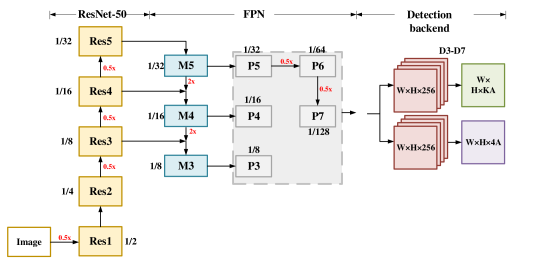

## Bottom Layer of ResNet50

In [8]:
def get_backbone():
  backbone = tf.keras.applications.ResNet50(
      include_top = False, input_shape=[None, None, 3], weights = 'imagenet'
  )
  for layer in backbone.layers:
    layer.trainable = False
  c3_output, c4_output, c5_output = [backbone.get_layer(layer).output for layer in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]]  #feature maps of strides 8,16,32
  return tf.keras.models.Model(inputs = [backbone.inputs], outputs = [c3_output, c4_output, c5_output])

## Building the Feature Pyramid Network

In [9]:
class FeaturePyramid(tf.keras.layers.Layer):
  def __init__(self, backbone=None, **kwargs):
    super(FeaturePyramid, self).__init__(name = "FeaturePyramid", **kwargs)
    self.backbone = backbone if backbone else get_backbone()
    self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
    self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
    self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
    self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
    self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
    self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
    self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
    self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
    self.upsample = tf.keras.layers.UpSampling2D(2)
  
  def call(self, images, training=False):
    c3_output, c4_output, c5_output = self.backbone(images, training=training)
    p3_output = self.conv_c3_1x1(c3_output)
    p4_output = self.conv_c4_1x1(c4_output)
    p5_output = self.conv_c5_1x1(c5_output)
    p4_output = p4_output + self.upsample(p5_output)
    p3_output = p3_output + self.upsample(p4_output)

    p3_output = self.conv_c3_3x3(p3_output)
    p4_output = self.conv_c4_3x3(p4_output)
    p5_output = self.conv_c5_3x3(p5_output)
    p6_output = self.conv_c6_3x3(c5_output)
    p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
    return p3_output, p4_output, p5_output, p6_output, p7_output

## Box Regression and Classification Subnets

In [10]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(tf.keras.layers.Conv2D(output_filters,3,1,padding="same",kernel_initializer=kernel_init,bias_initializer=bias_init))
    return head

##Implementing RetinaNet Architecture

In [11]:
class RetinaNet(tf.keras.Model):
  def __init__(self,num_classes, backbone = None, **kwargs):
    super(RetinaNet, self).__init__(name='RetinaNet', **kwargs)
    self.fpn = FeaturePyramid(backbone)
    self.num_classes = num_classes
    
    prior_probability = tf.constant_initializer(-np.log((1-0.01)/0.01)) #bias initializer for the classification subnet
    self.cls_head = build_head(9*num_classes, prior_probability)
    self.box_head = build_head(9*4, 'zeros')

  def call(self,image,training = False):
    features = self.fpn(image, training=training) #taking outputs fof fpn
    N = tf.shape(image)[0]
    cls_outputs = []
    box_outputs = []
    for feature in features:
      box_outputs.append(tf.reshape(self.box_head(feature), [N,-1,4]))
      cls_outputs.append(tf.reshape(self.cls_head(feature), [N,-1,self.num_classes])) 
    cls_outputs = tf.concat(cls_outputs, axis=1)
    box_outputs = tf.concat(box_outputs, axis=1)
    return tf.concat([box_outputs, cls_outputs], axis = -1)

## Custom Layer for Decoding Predictions of the RetinaNet Model

In [12]:
class DecodePredictions(tf.keras.layers.Layer):
  def __init__(self, num_classes=80, confidence_threshold=0.05,nms_iou_threshold=0.5,max_detections_per_class=100,max_detections=100,box_variance=[0.1, 0.1, 0.2, 0.2],**kwargs):
    super(DecodePredictions, self).__init__(**kwargs)
    self.num_classes = num_classes
    self.confidence_threshold = confidence_threshold
    self.nms_iou_threshold = nms_iou_threshold
    self.max_detections_per_class = max_detections_per_class
    self.max_detections = max_detections
    self._anchor_box = AnchorBox()
    self._box_variance = tf.convert_to_tensor([0.1, 0.1, 0.2, 0.2], dtype=tf.float32)
  
  def _decode_box_predictions(self, anchor_boxes, box_predictions):
    boxes = box_predictions * self._box_variance
    boxes = tf.concat([boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                       tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:]], axis=-1)
    boxes_transformed = convert_to_corners(boxes)
    return boxes_transformed

  def call(self, images, predictions):
    image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
    anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
    box_predictions = predictions[:, :, :4]
    cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
    boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)
    return tf.image.combined_non_max_suppression(
        tf.expand_dims(boxes, axis=2),
        cls_predictions,
        self.max_detections_per_class,
        self.max_detections,
        self.nms_iou_threshold,
        self.confidence_threshold,
        clip_boxes=False
        )

## Creating Loss Functions

### Box Regression Loss

In [13]:
class RetinaNetBoxLoss(tf.losses.Loss):
    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):
    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss


# Initializing RetinaNet Model

In [14]:
num_classes = 80
batch_size = 2

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates)
# initial_learning_rate = 2.5e-06
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100,
#     decay_rate=0.9)


resnet_50 = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet_50)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(
    optimizer = optimizer,
    loss = loss_fn
)

# Loading Dataset

In [24]:
import tensorflow_datasets as tfds

(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)

In [36]:
for sample in train_dataset.take(4):
  print(sample['bbox'])

tf.Tensor([0.26426426 0.11       0.996997   0.772     ], shape=(4,), dtype=float32)
tf.Tensor([0.196      0.2627346  0.866      0.65683645], shape=(4,), dtype=float32)
tf.Tensor([0.586     0.2102102 0.864     0.9369369], shape=(4,), dtype=float32)
tf.Tensor([0.25490198 0.406      0.6442577  0.808     ], shape=(4,), dtype=float32)


# Data Pipeline

In [38]:
label_encoder = LabelEncoder()

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

ValueError: ignored

# Training

In [17]:
history = model.fit(
    train_dataset.take(250),
    validation_data = val_dataset.take(50),
    epochs = 100
)

Epoch 1/100
250/250 [==============================] - 177s 662ms/step - loss: 10.5011 - val_loss: 9.8308
Epoch 2/100
250/250 [==============================] - 81s 322ms/step - loss: 9.8985 - val_loss: 9.3297
Epoch 3/100
250/250 [==============================] - 78s 310ms/step - loss: 9.0966 - val_loss: 9.6429
Epoch 4/100
250/250 [==============================] - 81s 320ms/step - loss: 8.9383 - val_loss: 9.2248
Epoch 5/100
250/250 [==============================] - 80s 317ms/step - loss: 8.9483 - val_loss: 10.4892
Epoch 6/100
250/250 [==============================] - 78s 309ms/step - loss: 8.4427 - val_loss: 10.1362
Epoch 7/100
250/250 [==============================] - 77s 306ms/step - loss: 8.6341 - val_loss: 9.8480
Epoch 8/100
250/250 [==============================] - 78s 310ms/step - loss: 8.7238 - val_loss: 9.8470
Epoch 9/100
250/250 [==============================] - 78s 311ms/step - loss: 8.3997 - val_loss: 9.8784
Epoch 10/100
250/250 [==============================] - 79s 

In [18]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions) 
inference_model = tf.keras.Model(inputs=image, outputs=detections)

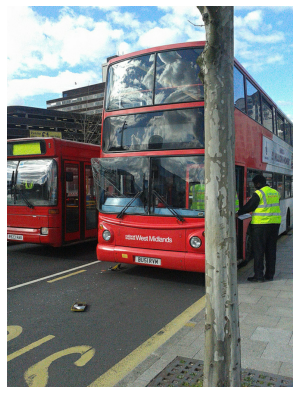

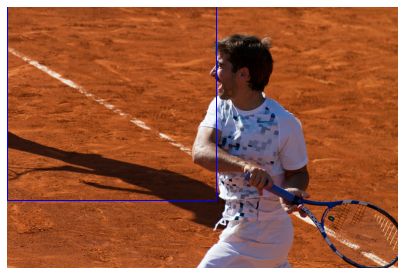

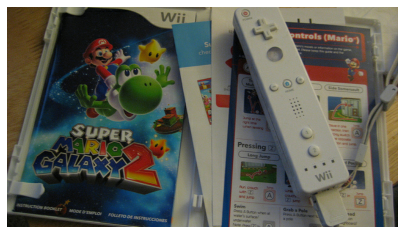

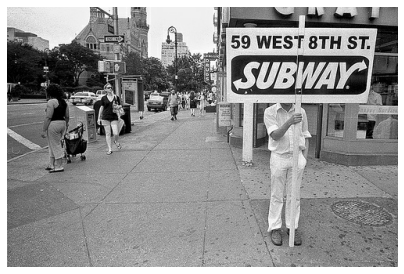

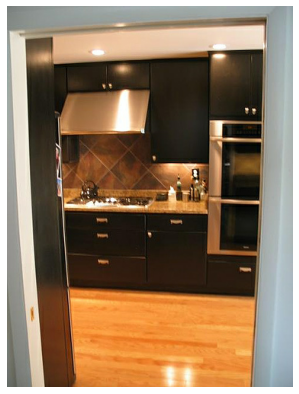

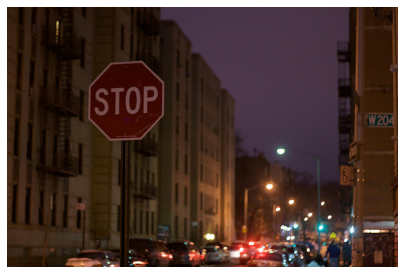

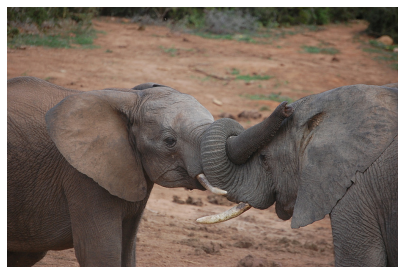

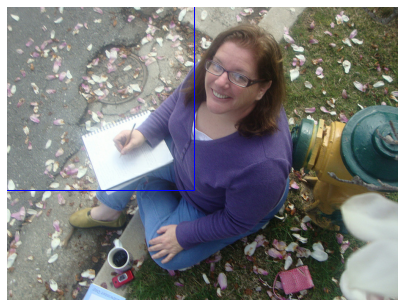

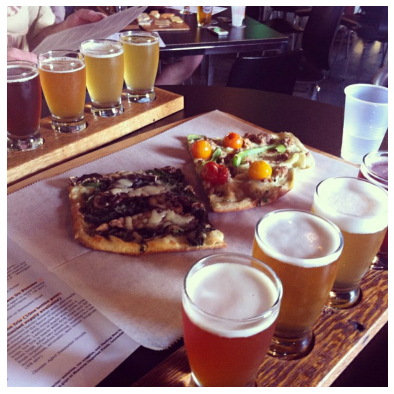

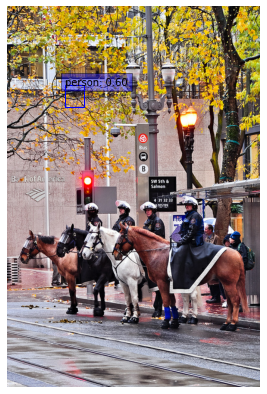

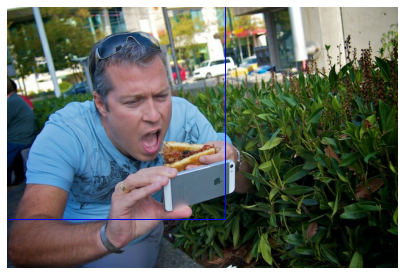

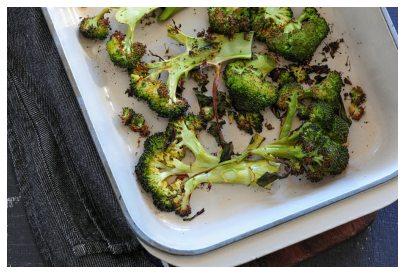

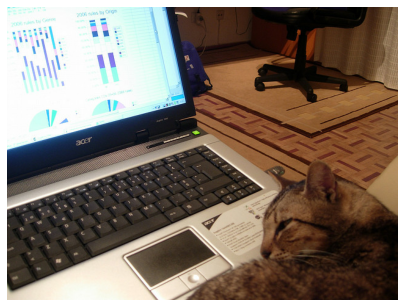

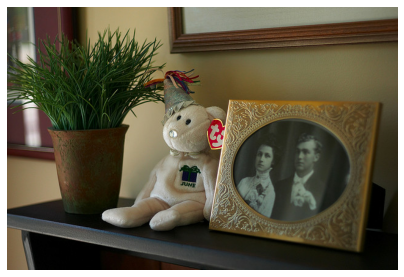

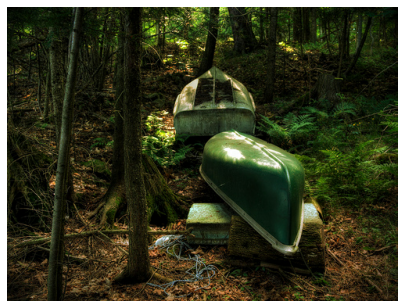

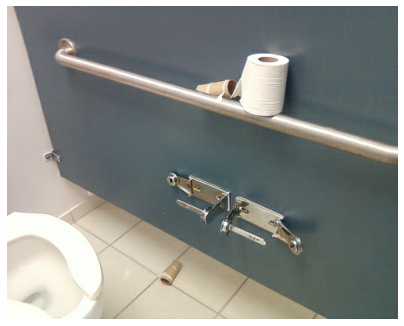

NotFoundError: ignored

In [22]:
def prepare_image(image):
    image, _, ratio = resize_pad_img(image, jitter=None)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio
    
val_dataset = tfds.load("coco/2017", split="validation", data_dir="data")
int2str = dataset_info.features["label"].int2str

for sample in val_dataset.take(23):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )